In [1]:
# Imports & global config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder, StandardScaler
from sklearn.decomposition   import TruncatedSVD
from sklearn.ensemble        import IsolationForest
from sklearn.metrics         import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


In [2]:
# Helper: load & prepare a CSV (+labels)
def load_and_prepare(path_csv, path_labels=None):
    """
    Load a transactions CSV and optional labels JSON.
    Adds hour_of_day & day_of_week. Supports either
    string or numeric amount.
    """
    df = pd.read_csv(
        path_csv,
        usecols=["id", "date", "amount", "merchant_city", "mcc"]
    )
    df["date"] = pd.to_datetime(df["date"])

    # robust amount cleaning
    if pd.api.types.is_numeric_dtype(df["amount"]):
        df["amount"] = df["amount"].astype(float)
    else:
        df["amount"] = (
            df["amount"]
              .astype(str)
              .str.replace(r"[$,]", "", regex=True)
              .astype(float)
        )

    df = df.rename(columns={"id": "transaction_id",
                            "merchant_city": "location"})
    df["hour_of_day"] = df["date"].dt.hour
    df["day_of_week"] = df["date"].dt.weekday

    if path_labels is not None:
        lbl = (
            pd.read_json(path_labels)
              .reset_index()
              .rename(columns={"index": "transaction_id"})
              .replace({"target": {"Yes": 1, "No": 0}})
        )
        df = df.merge(lbl, on="transaction_id")

    # inject target column if it exists
    df_target = pd.read_csv(path_csv)
    if "target" in df_target.columns:
        df["target"] = df_target["target"].astype(int)

    return df

In [3]:
# ColumnTransformer + SVD reducer
cat_cols = ["location", "mcc"]
num_cols = ["amount", "hour_of_day", "day_of_week"]

base_pre = ColumnTransformer(
    transformers=[
        ("cat",
         OneHotEncoder(handle_unknown="ignore",
                       sparse_output=True,
                       dtype=np.int8),
         cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    sparse_threshold=0.3
)

# Reduce high-dim sparse matrix to 200 dense features
svd = TruncatedSVD(
        n_components=200,
        algorithm="randomized",
        n_iter=5,
        random_state=RANDOM_STATE
)


In [4]:
# Train Isolation Forest on Kaggle
kag_csv   = "assets/kaggle_data/transactions_data.csv"
kag_lbl   = "assets/kaggle_data/train_fraud_labels.json"

train_df  = load_and_prepare(kag_csv, kag_lbl)
y_train   = train_df["target"]
X_train   = train_df.drop(columns=["transaction_id", "date", "target"])

# 1️⃣  sparse one-hot/scaled  →  2️⃣  SVD  →  dense 200-col
X_train_sparse   = base_pre.fit_transform(X_train)
scaler = StandardScaler()
X_train_reduced  = svd.fit_transform(X_train_sparse)
X_train_scaled   = scaler.fit_transform(X_train_reduced)

iso = IsolationForest(
        n_estimators=300,
        contamination=0.10,         # trim 10 % of the data
        max_samples="auto",
        n_jobs=-1,
        random_state=RANDOM_STATE
)
iso.fit(X_train_scaled)

# Keep only normal points for AE training
mask_keep   = iso.predict(X_train_scaled) == 1
X_ae_dense  = scaler.transform(X_train_reduced[mask_keep]).astype("float32")
print("AE training set shape:", X_ae_dense.shape)


/var/folders/gd/d2vxxv2x60j28jw85n3wg5dw0000gn/T/ipykernel_18059/3860006748.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"target": {"Yes": 1, "No": 0}})


AE training set shape: (8023477, 200)


In [5]:
# Autoencoder architecture & training
n_in       = X_ae_dense.shape[1]      # 200
enc_units  = 128
bottleneck = 32
dec_units  = 128

inp = layers.Input(shape=(n_in,))
x   = layers.Dense(enc_units,  activation="relu")(inp)
x   = layers.Dense(bottleneck, activation="relu")(x)
x   = layers.Dense(dec_units,  activation="relu")(x)
out = layers.Dense(n_in,       activation="linear")(x)

ae = models.Model(inp, out)
ae.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),     # ↓ safer LR
    loss=losses.MeanSquaredError()
)

early   = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
plateau = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

history = ae.fit(
    X_ae_dense, X_ae_dense,
    epochs=100, batch_size=512, shuffle=True,
    validation_split=0.1,
    callbacks=[early, plateau], verbose=2
)


2025-05-21 14:38:36.014352: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-21 14:38:36.015533: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-21 14:38:36.015547: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-05-21 14:38:36.015860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 14:38:36.015872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-05-21 14:38:47.052495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


14104/14104 - 89s - 6ms/step - loss: 0.9009 - val_loss: 1.9435 - learning_rate: 1.0000e-04
Epoch 2/100
Epoch 2/100
14104/14104 - 88s - 6ms/step - loss: 48.0262 - val_loss: 84.7341 - learning_rate: 1.0000e-04
Epoch 3/100
14104/14104 - 90s - 6ms/step - loss: 652.2208 - val_loss: 1843.2992 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
14104/14104 - 89s - 6ms/step - loss: 6362.7920 - val_loss: 16789.6016 - learning_rate: 1.0000e-04
Epoch 5/100
14104/14104 - 89s - 6ms/step - loss: 17174.4258 - val_loss: 25392.8359 - learning_rate: 5.0000e-05
Epoch 6/100
14104/14104 - 88s - 6ms/step - loss: 32415.6055 - val_loss: 44135.9219 - learning_rate: 5.0000e-05


In [6]:
# Compute AE threshold (99.99 percentile)
val_size  = int(0.1 * len(X_ae_dense))
recon_val = ae.predict(X_ae_dense[:val_size], batch_size=512, verbose=0)
err_val   = np.mean(np.square(recon_val - X_ae_dense[:val_size]), axis=1)

THRESH = np.percentile(err_val, 99.99)
print(f"Reconstruction-error threshold = {THRESH:.6f}")


Reconstruction-error threshold = 68.925407


In [7]:
# Predict on chatgpt_data set
test_csv = "assets/chatgpt_data/transactions_o3_2_test.csv"
test_lbl = None   # set path if you have labels

test_df   = load_and_prepare(test_csv, test_lbl)
has_label = "target" in test_df.columns
if has_label:
    y_test = test_df["target"]

X_test = test_df.drop(columns=["transaction_id", "date"] +
                                (["target"] if has_label else []))

# Stage 1 — IF
X_test_sparse   = base_pre.transform(X_test)
X_test_reduced  = svd.transform(X_test_sparse)
X_test_scaled   = scaler.transform(X_test_reduced)

if_flag = (iso.predict(X_test_scaled) == -1).astype(int)

# Stage 2 — AE
recon_test = ae.predict(X_test_scaled.astype("float32"),
                        batch_size=1024, verbose=0)
err_test   = np.mean(np.square(recon_test - X_test_scaled), axis=1)
ae_flag    = (err_test > THRESH).astype(int)

y_pred = (if_flag | ae_flag)


Accuracy : 0.8932
Precision: 0.08561643835616438
Recall   : 1.0
F1       : 0.15772870662460567


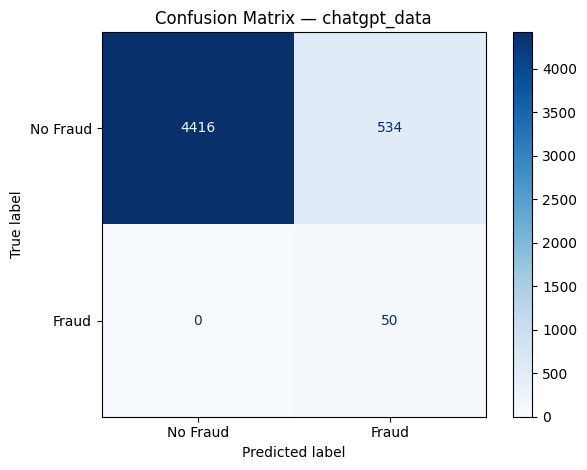

In [8]:
# Metrics
if has_label:
    print("Accuracy :",  accuracy_score(y_test, y_pred))
    print("Precision:",  precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :",  recall_score(y_test, y_pred))
    print("F1       :",  f1_score(y_test, y_pred))

    cm   = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix — chatgpt_data")
    plt.tight_layout()
    plt.show()
else:
    print("Predictions generated (no ground-truth labels supplied).")